# Recommendations with IBM

This notebook uses on real data from the IBM Watson Studio platform.We will be putting our recommendation skills to bulit a good recommentation engine. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

### <a class="anchor" id="Exploratory-Data-Analysis">Part 0 : Getting To Know About Data </a>

`1.`We will be importing necessary libraries and load  "user-item-interactions.csv" and "articles_community.csv" and display it contents

In [37]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

#load data

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [38]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [39]:
# get shape of both dataframe 
df.shape,df_content.shape

((45993, 3), (1056, 5))

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` We will be exploring the  distribution of how many articles a user interacts with in the dataset and  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

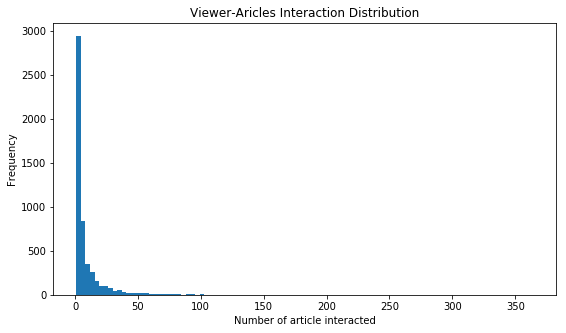

In [40]:
# create distribution plot for interaction between viewers & articles

hist_plot = df.groupby("email").count().article_id.values

fig , ax = plt.subplots(figsize=(9, 5))

plt.hist(hist_plot , bins = 100)
plt.title("Viewer-Aricles Interaction Distribution")
plt.xlabel("Number of article interacted") , plt.ylabel("Frequency")
plt.show()

In [41]:
#display the number of unique title and email ids
df.title.nunique(),df.email.nunique()

(714, 5148)

In [42]:
# descriptive statistcs for the interaction between viewers & articles
df.groupby("email").count().article_id.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

#### Key Notes:
> `1.`Average number of article interacted per user is around **8**.<br>
  `2.` 50% of individuals interact with 3 articles or fewer.<br>
  `3.` The maximum number of user-article interactions by any 1 user is 364


In [43]:
# store median and maximum number of user_article interactios in variables
# we may need it for future use

median_val = np.median(df.groupby("email").count().article_id.values)
max_views_by_user = df.groupby("email")["article_id"].count().values.max()

int(median_val),max_views_by_user

(3, 364)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [44]:
# Find and explore duplicate articles
df_content[df_content.article_id.duplicated(keep = False)].sort_values(by=['article_id'])

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [45]:
# Remove any rows that have the same article_id - only keep the first
df_content =  df_content.drop_duplicates(['article_id'], keep = "first")

#### Key Notes:
> `1.` We have **5** duplicated values article id.It seems to be have differnt upadtes of the ids.<br>

`3.` We will try to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [46]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content["article_id"].nunique() # The number of unique articles on the IBM platform
unique_users = df["email"].nunique()# The number of unique users
user_article_interactions = len(df)# The number of user-article interactions

unique_articles , total_articles , unique_users ,user_article_interactions

(714, 1051, 5148, 45993)

`4.` 
   - We will be finding the most viewed **article_id**, as well as how often it was viewed.<br>
   - We will create a `email_mapper` function  to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [47]:
# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id = df.groupby("article_id").count().sort_values(by=['email'],ascending =False).head(1).index.to_list()[0]
# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby("article_id").count().sort_values(by=['email'],ascending =False).head(1).email.to_list()[0]

most_viewed_article_id,max_views

(1429.0, 937)

In [48]:
# Fuction to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict  = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Here, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` We will create a  function to return the **n** top articles ordered with most interactions as the top.

In [49]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    
    '''
    # get top articles titles in decs order
    sorted_series = df.groupby("title").count().article_id.sort_values(ascending=False)
    
    # top n articles
    top_articles = sorted_series[:n].index.to_list()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
     # get top article ids
    top_articles = df["article_id"].value_counts().iloc[:n].index.to_list()
 
    return top_articles # Return the top article ids

In [50]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` We will reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.Below are the condition needs to be satisfied:

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [51]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    #create the user-article matrix
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    
    #change the value to 1 for all interactions
    user_item = user_item/user_item
    
    #fill Nans to 0 to represent no interactions
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` Here we will create a function  which :
 - will take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).
 - The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it is therfore  makes sense to compute similarity as the dot product between two users. 


In [52]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user & remove the own user's id
    similarity_df  = user_item[user_item.index == user_id].dot(user_item[user_item.index != user_id].T)

    # sort by similarity & create list of just the ids
    most_similar_users = similarity_df.sort_values(user_id, axis=1, ascending=False).columns.to_list()


       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [53]:
# spot check the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` The functions below will return the articles we would recommend to each user.

In [54]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df.article_id.isin(article_ids)].title.unique()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    #get article ids
    article_ids = user_item.loc[user_id][user_item.loc[user_id]!=0].index.to_list()
    # Convert floats to strings
    article_ids = [str(x) for x in article_ids]
    #get article names
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs  = []
    # user read articles
    userr_article_ids, userr_article_names = get_user_articles(user_id)
    
    #similar users order
    similar_user_order = find_similar_users(user_id)
    for simuser_id in similar_user_order:
            sim_article_ids, sim_article_names = get_user_articles(simuser_id)
            suggested_articles = user_item.loc[user_id][[int(float(x)) for x in sim_article_ids]]
            #print(suggested_articles)
            recs  = recs + suggested_articles[suggested_articles != 1].index.to_list()
            if len(recs)>m:
                break
            
    return recs[:m] # return your recommendations for this user_id    

In [55]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'graph-based machine learning',
       'using brunel in ipython/jupyter notebooks',
       'experience iot with coursera',
       'the 3 kinds of context: machine learning and the art of the frame',
       'deep forest: towards an alternative to deep neural networks',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty'],
      dtype=object)

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [56]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
    
    #assign similiary for each users
    neighbors_df["neighbor_id"] = find_similar_users(user_id)
    
    #assign num of interactionns
    neighbors_df["similarity"] = neighbors_df.neighbor_id.apply(lambda x: user_item.T[user_id].values.dot(user_item.T[x].values))
    
    #sort values as similarity and then num_interactions
    neighbors_df['num_interactions'] = neighbors_df.neighbor_id.apply(lambda x:user_item.loc[x].sum())
    
    neighbors_df.sort_values(by=['similarity','num_interactions'], ascending=[False,False],inplace =True)
    
    neighbors_df.reset_index(inplace=True , drop=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs  = []
    # user read articles
    userr_article_ids, userr_article_names = get_user_articles(user_id)
        
    # Find similar users
    similar_user_order = get_top_sorted_users(user_id).rename({"neighbor_id": "user_id"}, axis=1)
    
    #choosing the articles based on higher order
    for simuser_id in similar_user_order.user_id.to_list():
            sim_article_ids, sim_article_names = get_user_articles(simuser_id)
            suggested_articles = user_item.loc[user_id][[int(float(x)) for x in sim_article_ids]]
            recs  = recs + suggested_articles[suggested_articles != 1].index.to_list()
            if len(recs)>m:
                break
    rec_names  = get_article_names(recs[:m])
    return recs[:m], rec_names

In [57]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12, 14, 29, 33, 43, 51, 109, 111, 130, 142]

The top 10 recommendations for user 20 are the following article names:
['got zip code data? prep it for analytics. – ibm watson data lab – medium'
 'timeseries data analysis of iot events by using jupyter notebook'
 'deep learning with tensorflow course by big data university'
 'using brunel in ipython/jupyter notebooks'
 'tidy up your jupyter notebooks with scripts'
 'experience iot with coursera' 'tensorflow quick tips'
 'neural networks for beginners: popular types and applications'
 'modern machine learning algorithms'
 "feature importance and why it's important"]


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Here we will load the pickle object of  the  already created a **user_item** matrix of **Part III** above. 

In [58]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [59]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Here we will  use Singular Value Decomposition on the user-item matrix.

In [60]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

### Note:
> Since we have taken care of all missing value(we have replaced all Nan values with 0's ) we can use SVD here, otherwisewe would have needed to use FunkSVD.

`3.` Here we will see how the in increase the number of latent features affect the accuracy.

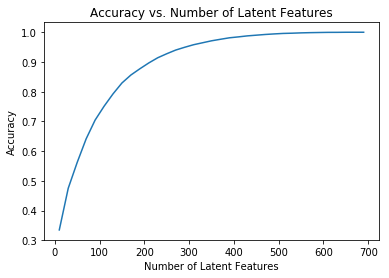

In [61]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

### Key Note:
>  - From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.

`4.`  we will split our dataset into a training and test set of data.  

In [62]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = set(user_item_test.index.tolist())
    test_idx = set(user_item_test.index.tolist())
    
    dup_idx = list(train_idx.intersection(test_idx))
    
    train_arts = set(user_item_train.columns.tolist())
    test_arts = set(user_item_test.columns.tolist())
    dup_arts = list(train_arts.intersection(test_arts))
    
    user_item_test = user_item_test.loc[dup_idx, dup_arts]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

`5.` Here we will:
   - use the **user_item_train** dataset from above to find U, S, and V transpose using SVD.
   - Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.


In [63]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [64]:
# decomposition to predict on test data
row_idxs = user_item_train.index.isin(test_idx)
cols_idxs = user_item_train.columns.isin(test_arts)

# u_test & vt_test
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, cols_idxs]

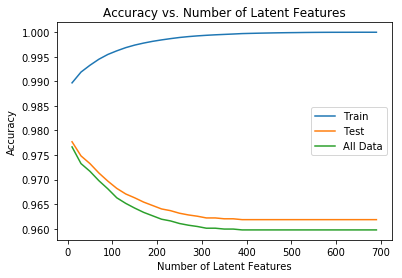

In [65]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []
accuracy = []
user_item_test = user_item_test.loc[set(user_item_test.index.tolist())&set(user_item_train.index.tolist()) ,:]

for k in num_latent_feats:
    
    # restructure with k latent features
    s_tr, u_tr, vt_tr = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_ts, vt_ts = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_tr = np.around(np.dot(np.dot(u_tr, s_tr), vt_tr))
    user_item_ts = np.around(u_ts.dot(s_tr).dot(vt_ts))
    
     # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_tr)
    diffs_test = np.subtract(user_item_test, user_item_ts)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(train_err)
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(test_err)
    
    # append errors
    accuracy.append( 1-(user_item_ts.sum()+user_item_test.values.sum()) / (user_item_test.shape[0]*user_item_test.shape[1]))
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), 
         label='Train');

plt.plot(num_latent_feats, 
         1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), 
         label='Test');
plt.plot(num_latent_feats, 
         accuracy, 
         label='All Data');
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()
       

### Conclusion
   - In training set we can see that ,when we increase latent features results in overfitting.Overall ,this worses the accuracy of the model.
   - Since have only few common users in both train  and train,collaborative filtering or content based recommendation seems to give better results
   - We could try using A/B to see how well it performs in production